In [3]:

# Импортируем бибилиотеи для анализа
import pandas as pd
import numpy as np

# Импортируем бибилиотеки для визуализации

import matplotlib.pyplot as plt
import seaborn as sns
sns.__version__

'0.13.1'

In [ ]:
# Загружаем файлы
from google.colab import files
files.upload()
files.upload()


In [4]:
covid_data = pd.read_csv('full_grouped.csv')
vaccin_data = pd.read_csv('country_vaccinations.csv')

Сменим все колонки covid_data на нижний регист для простоты работы

In [5]:
covid_data.rename(columns={'Country/Region': 'country'}, inplace=True)
covid_data.columns = covid_data.columns.str.lower()

В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.

В таблицах не совпадает число стран, а иногда и их названия.

При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.

Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.

Для таблицы covid_data сделаем следующее:

Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [6]:
covid_data = covid_data.groupby(['date', 'country'], as_index=False)[['confirmed', 'deaths', 'recovered']].sum()


Преобразуем даты в формат datetime с помощью функции pd.to_datetime()

In [7]:
covid_data['date'] = pd.to_datetime(covid_data['date'],dayfirst=False)


Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [8]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по датам, а затем по названиям стран. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [9]:
covid_data = covid_data.sort_values(by=['country','date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()


In [10]:
vaccin_data['date'] = pd.to_datetime(vaccin_data['date'])

In [11]:
covid_df = pd.merge(covid_data,vaccin_data, on =['date','country'],how='left')

In [12]:
covid_df['deaths_rate'] = covid_df['deaths'] / covid_df['confirmed'] * 100
covid_df['recover_rate'] = covid_df['recovered'] / covid_df['confirmed'] * 100

In [13]:
max_death_rate_usa = covid_df[covid_df['country'] == 'united States']['deaths_rate'].max()
recover_rate_in_russia = covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean()
display(round(recover_rate_in_russia,2))

38.32

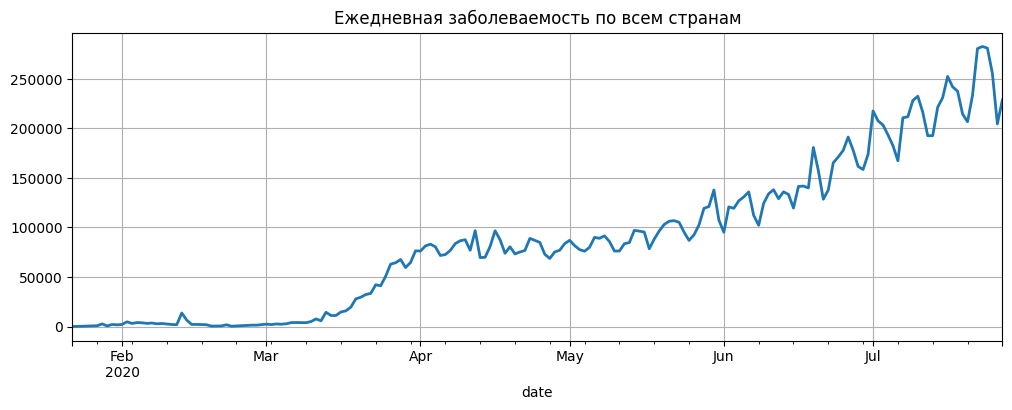

In [14]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12,4),
    title='Ежедневная заболеваемость по всем странам',
    grid = True,
    lw=2
);

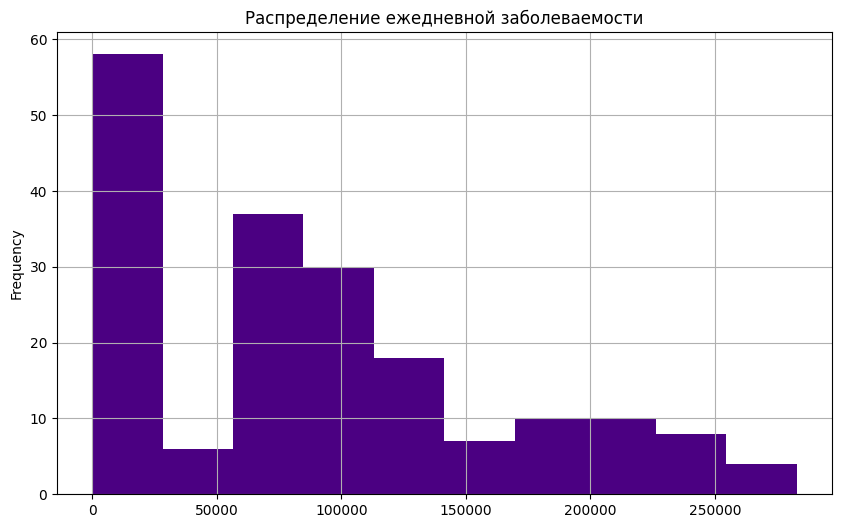

In [17]:

grouped_cases.plot(
    kind='hist',
    figsize = (10,6),
    title = 'Распределение ежедневной заболеваемости',
    grid = True,
    color = 'indigo',
    bins= 10
);

<Axes: xlabel='country'>

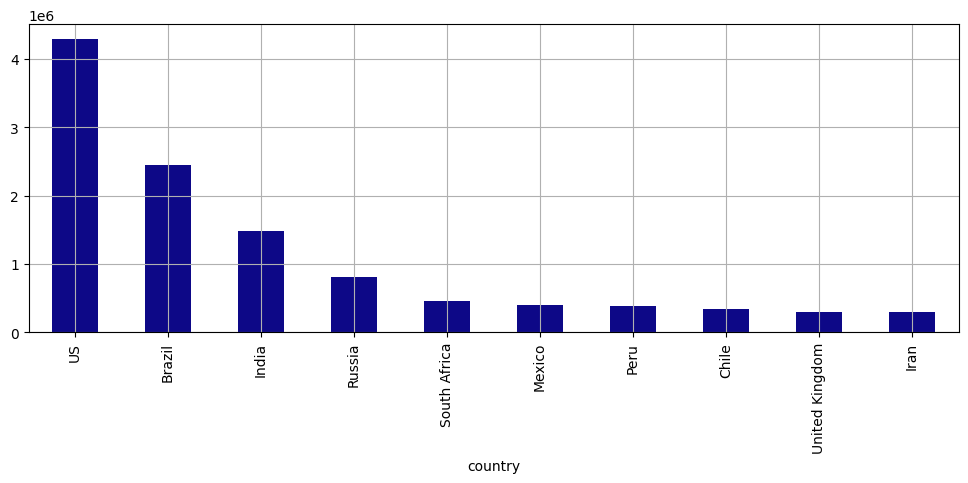

In [16]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country.nlargest(10).plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'

)

Например, изобразим на одном графике, как росла общая заболеваемость (confirmed), число зафиксированных смертей (deaths), выздоровевших пациентов (recovered) и активных случаев (active) в Китае.

Для построения линейных графиков в Matplotlib используется метод plot()

Важно! Не путайте его с методом plot() в Pandas!

При вызове метода без параметров по оси ординат откладываются значения столбца таблицы, по оси абсцисс — индексы (в нашем случае это будут даты).

Дополнительно в параметрах метода указываем параметр label — название графика, которое будет отображаться на легенде, а также lw — ширину линии графика. Добавим к графику заголовок, названия осей, установим метки по оси y с частотой в 10 000, повернём метки по оси x на 30 градусов, а также добавим легенду (метки для легенды выставляются в параметре label метода plot()):

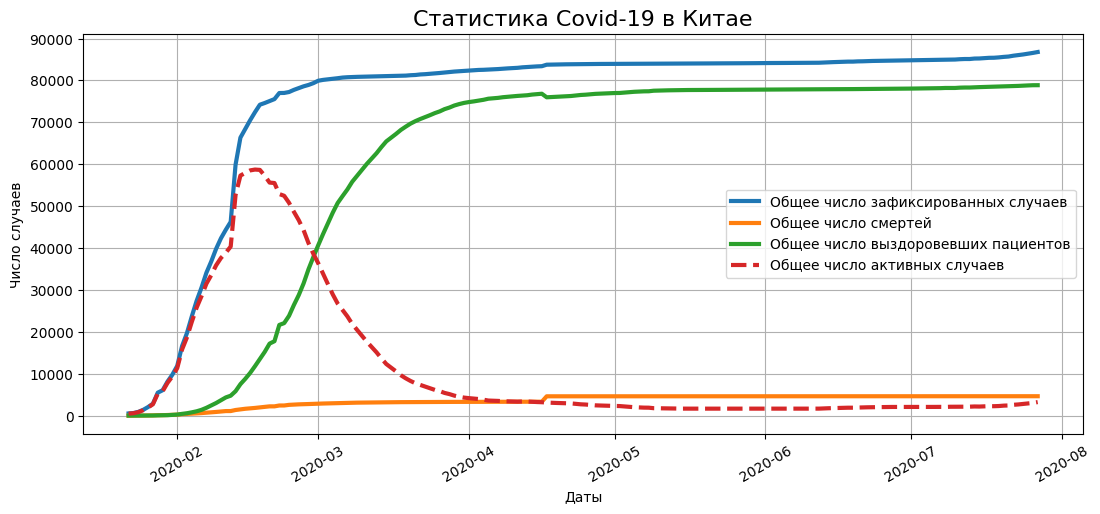

In [18]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

Важно! Вы можете размещать несколько систем координат на одной фигуре, что позволит нам отображать вспомогательную информацию на основном графике. Для добавления второй системы координат необходимо повторно применить к объекту fig метод add_axes, указав новое имя для второй системы координат.

Группируем таблицу по странам, находим последний по дате зафиксированный показатель с помощью метода last() и выбираем ТОП-5 стран с использованием метода nlargest(). При отображении графиков создаём две координатные плоскости main_axes и insert_axes, на каждой из них отдельно строим столбчатые диаграммы.

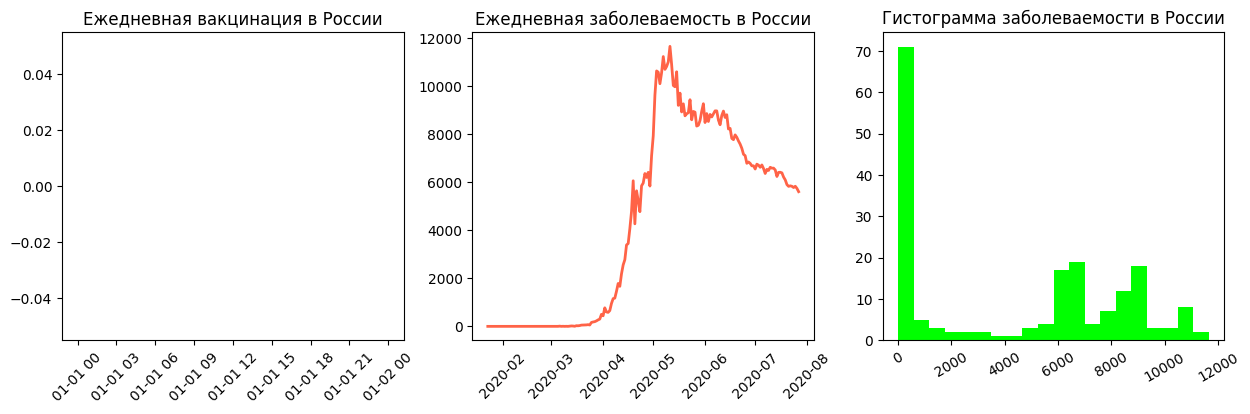

In [19]:
russia_data = covid_df[covid_df['country'] == 'Russia']

#визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

#столбчатая диаграмма
axes[0].bar(x=russia_data['date'],
    height=russia_data['daily_vaccinations'],
    label='Число вакцинированных'
)
axes[0].set_title('Ежедневная вакцинация в России')
axes[0].xaxis.set_tick_params(rotation=45)

#линейный график
axes[1].plot(russia_data['date'],
    russia_data['daily_confirmed'],
    label='Число заболевших',
    color='tomato', lw=2
)
axes[1].set_title('Ежедневная заболеваемость в России')
axes[1].xaxis.set_tick_params(rotation=45)

#гистограмма
axes[2].hist(x=russia_data['daily_confirmed'],
    label=['Число заболевших'],
    color='lime', bins = 20
)
axes[2].set_title('Гистограмма заболеваемости в России')
axes[2].xaxis.set_tick_params(rotation=30)

Мы рассмотрели лишь основные графики и их настройки в библиотеке Matplotlib. На самом деле библиотека имеет гораздо больший спектр возможностей, на изучение которого не хватит даже целого курса по визуализации, — от добавления текста на диаграмму до визуализации изображений и 3D-графиков.

Также стоит отметить, что, помимо объектно-ориентированного подхода в работе с библиотекой Matplotlib, вы можете встретить и модульный подход.

Модульный подход основан на обращении к модулю pyplot (plt) напрямую, а не средствами объектов фигур и плоскостей.

<BarContainer object of 5 artists>

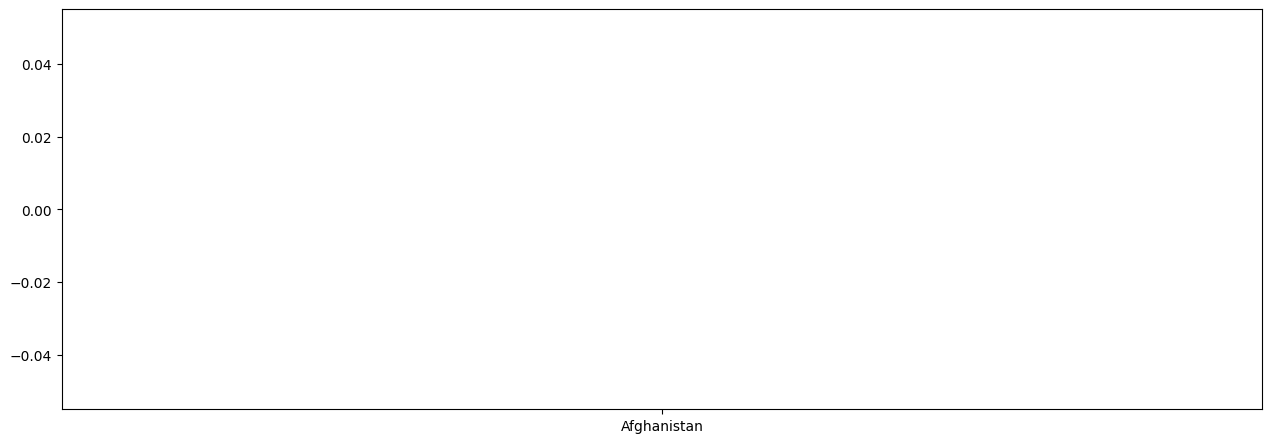

In [20]:

v = covid_df.groupby(['country'])['total_vaccinations'].last().nlargest(5)
fig = plt.figure(figsize=(12, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=v.index,height=v)

In [21]:

countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,iso_code,...,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website,deaths_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-22,Australia,0,0,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-23,Australia,0,0,0,0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,0.000000
2,2020-01-24,Australia,0,0,0,0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,0.000000
3,2020-01-25,Australia,0,0,0,0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,0.000000
4,2020-01-26,Australia,4,0,0,4,4.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016


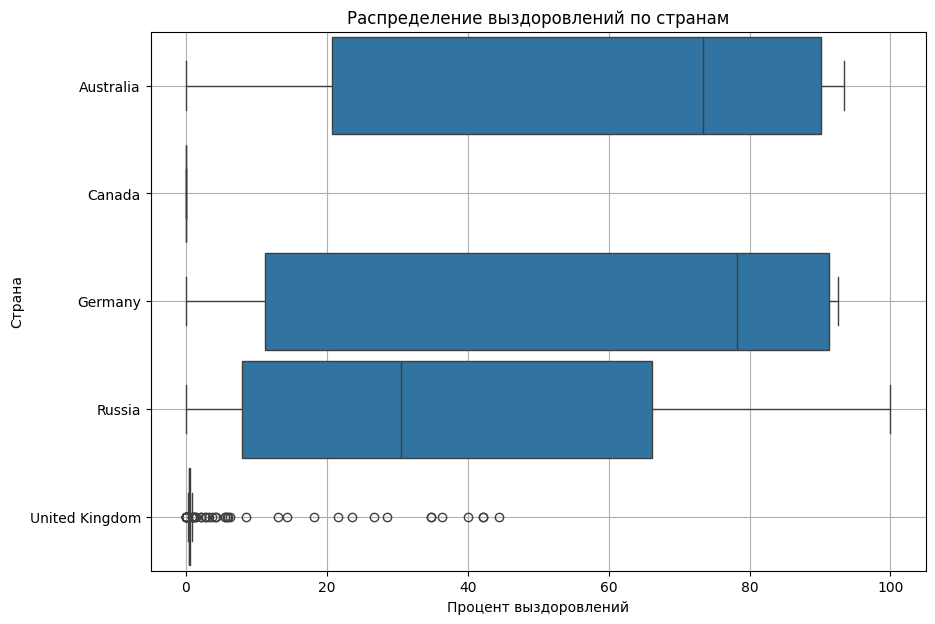

In [22]:

fig2 = plt.figure(figsize=(10, 7))
recover_rate = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    orient='h',
    width=0.9
)
recover_rate.set_title('Распределение выздоровлений по странам');
recover_rate.set_xlabel('Процент выздоровлений');
recover_rate.set_ylabel('Страна');
recover_rate.grid()

In [23]:

import plotly
import plotly.express as px

In [24]:

covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35156 entries, 0 to 35155
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 35156 non-null  datetime64[ns]
 1   country                              35156 non-null  object        
 2   confirmed                            35156 non-null  int64         
 3   deaths                               35156 non-null  int64         
 4   recovered                            35156 non-null  int64         
 5   active                               35156 non-null  int64         
 6   daily_confirmed                      34969 non-null  float64       
 7   daily_deaths                         34969 non-null  float64       
 8   daily_recovered                      34969 non-null  float64       
 9   iso_code                             0 non-null      object        
 10  total_vacc

In [25]:

line_data = covid_df.groupby(by='date', as_index=False)['daily_vaccinations'].sum()
fig = px.line(data_frame=line_data, x='date', y='daily_vaccinations')
fig.show()

/usr/local/lib/python3.10/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()
